## Load packages

In [1]:
import numpy as np
import pandas as pd
import math
from keras import optimizers
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv1D
from keras.layers import AveragePooling1D, MaxPooling1D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *
import keras.backend as K
from matplotlib import pyplot
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from numpy.random import seed
seed(111)

Using TensorFlow backend.


## Load dataset

In [2]:
# import Matt's 'chr1_ukb_X.npz' file
chr1_ukb_X = np.load('/home/magu/deepmix/data/ALL_DNA_dataset/chr1_1kg_X.npz')
# create dict mapping from sampleid to population name
sampleid_to_population_pandas_df = pd.read_csv('/home/jsokol/Data/igsr_samples_cleaned_version.tsv', delimiter="\t")
sampleid_to_population_dict = sampleid_to_population_pandas_df.set_index('Sample name')['Population code'].to_dict()
# remove samples from chr1_ukb_X that are not in dict or that do not contain value
temp = set()
for x in np.nditer(chr1_ukb_X['S']):
    sample_id = str((x.item(0))).replace("'", "").replace("b", "").split("_")[0]
    if sample_id not in sampleid_to_population_dict:
        print(sample_id + ' is not in dict. Make sure to remove this sample from the dataset.')
    elif sampleid_to_population_dict[sample_id] == float('nan'):
        print(sample_id + ' maps to nan in dict')
chr1_ukb_X_G = chr1_ukb_X['G'][:,:,:]
chr1_ukb_X_V = chr1_ukb_X['V'][:,:]

In [3]:
# flatten input data
X_all_data = chr1_ukb_X_G.reshape(chr1_ukb_X_G.shape[0], -1).T

In [4]:
# create set of all populations represented in dataset
populations_represented_set = set()
for i in range(5008):
    sample_id = str(chr1_ukb_X['S'][i].item(0)).replace("'", "").replace("b", "").split("_")[0]
    populations_represented_set.add(sampleid_to_population_dict[sample_id])
# print total number of populations represented by dataset
n_classes = len(populations_represented_set)
print('Total number of classes minus classes deleted because they are admixed = ' + str(n_classes))
print(populations_represented_set)

Total number of classes minus classes deleted because they are admixed = 26
{'ESN', 'IBS', 'BEB', 'TSI', 'ASW', 'CHB', 'PJL', 'CHS', 'KHV', 'MXL', 'GBR', 'MSL', 'JPT', 'GIH', 'ACB', 'FIN', 'LWK', 'STU', 'PEL', 'YRI', 'CDX', 'CLM', 'ITU', 'PUR', 'GWD', 'CEU'}


In [5]:
# one hot encode labels and delete unwanted classes
Y_all_data = np.zeros((n_classes, 5008))
indices_to_delete = list()
for i in range(5008):
    sample_id = str(chr1_ukb_X['S'][i].item(0)).replace("'", "").replace("b", "").split("_")[0]
    if sampleid_to_population_dict[sample_id] == 'CDX':
        Y_all_data[0,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'KHV':
        Y_all_data[1,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'CHS':
        Y_all_data[2,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'CHB':
        Y_all_data[3,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'JPT':
        Y_all_data[4,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'PEL':
        Y_all_data[5,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'MXL':
        Y_all_data[6,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'CLM':
        Y_all_data[7,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'PUR':
        Y_all_data[8,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'IBS':
        Y_all_data[9,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'TSI':
        Y_all_data[10,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'CEU':
        Y_all_data[11,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'GBR':
        Y_all_data[12,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'FIN':
        Y_all_data[13,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'GIH':
        Y_all_data[14,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'PJL':
        Y_all_data[15,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'ITU':
        Y_all_data[16,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'STU':
        Y_all_data[17,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'BEB':
        Y_all_data[18,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'ACB':
        Y_all_data[19,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'ASW':
        Y_all_data[20,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'LWK':
        Y_all_data[21,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'ESN':
        Y_all_data[22,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'YRI':
        Y_all_data[23,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'MSL':
        Y_all_data[24,i] = 1
    elif sampleid_to_population_dict[sample_id] == 'GWD':
        Y_all_data[25,i] = 1
# delete samples with unwanted classes using 'indices_to_delete'
X_all_data = np.delete(X_all_data, indices_to_delete, 1)
Y_all_data = np.delete(Y_all_data, indices_to_delete, 1)

In [6]:
# randomly shuffle the order of the data
randomize = np.arange(X_all_data.shape[1])
np.random.shuffle(randomize)
X_all_data = X_all_data[:,randomize]
Y_all_data = Y_all_data[:,randomize]

In [7]:
# split data into training and test sets
X_train = X_all_data[:,:int(X_all_data.shape[1]*0.8)]
X_test = X_all_data[:,int(X_all_data.shape[1]*0.8):]
Y_train = Y_all_data[:,:int(X_all_data.shape[1]*0.8)]
Y_test = Y_all_data[:,int(X_all_data.shape[1]*0.8):]
# convert to correct format for use in keras
X_train = X_train[:,:,np.newaxis]
X_train = np.transpose(X_train, (1, 0, 2))
X_test = X_test[:,:,np.newaxis]
X_test = np.transpose(X_test, (1, 0, 2))
Y_train = np.transpose(Y_train, (1, 0))
Y_test = np.transpose(Y_test, (1, 0))

## Build model

In [8]:
def model2(n_snps_per_sample):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(shape=(n_snps_per_sample, 1))

    # First convolutional block
    X = Conv1D(filters=49, kernel_size=500 ,strides=500, padding = 'valid', name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)

    # Second convolutional block
    X = Conv1D(49, 75, strides = 5, padding = 'same', name = 'conv1')(X)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling1D(2, name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(n_classes, activation='softmax', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='model2')
    
    return model

## Create and compile the model 

In [9]:
## CREATE CONFUSION MATRIX MANUALLY
# 0) settings
confusion_matrix_spread = 0.86 # must be between 0 and 1
reverse_weights = False
# 1) create confusion matrix from 1000 genomes supplementary info handbook's info on relatedness
confusion_matrix = np.array([[0.0001,0.0019,0.0049,0.0086,0.0169,0.0864,0.0708,0.0766,0.0826,0.105,0.1051,0.106,0.1062,0.0991,0.073,0.0705,0.0685,0.0671,0.056,0.1405,0.1254,0.1524,0.1631,0.1613,0.1636,0.1581],[0.0019,0.0001,0.0033,0.0062,0.014,0.0823,0.0665,0.0726,0.0788,0.1008,0.1009,0.1016,0.1018,0.095,0.0687,0.0664,0.0643,0.0629,0.0521,0.1379,0.1224,0.1499,0.1608,0.1589,0.1611,0.1557],[0.0049,0.0033,0.0001,0.0011,0.0088,0.082,0.0677,0.0749,0.0816,0.1042,0.1043,0.105,0.1053,0.0977,0.0726,0.0702,0.0682,0.0669,0.0558,0.1418,0.1263,0.1538,0.1647,0.1627,0.1651,0.1595],[0.0086,0.0062,0.0011,0.0001,0.0069,0.0795,0.0652,0.0727,0.0796,0.1022,0.1023,0.1029,0.1032,0.0956,0.0712,0.0687,0.067,0.0657,0.0547,0.1405,0.1248,0.1525,0.1634,0.1614,0.1638,0.1582],[0.0169,0.014,0.0088,0.0069,0.0001,0.0798,0.0659,0.0738,0.0809,0.1039,0.1041,0.1046,0.1049,0.0971,0.0724,0.0701,0.0683,0.0668,0.0564,0.1419,0.1262,0.1538,0.1648,0.1628,0.1652,0.1595],[0.0864,0.0823,0.082,0.0795,0.0798,0.0001,0.0174,0.0391,0.0564,0.0856,0.0856,0.0844,0.0848,0.0806,0.074,0.0705,0.0742,0.0739,0.068,0.1377,0.119,0.1512,0.1619,0.1599,0.162,0.1517],[0.0708,0.0665,0.0677,0.0652,0.0659,0.0174,0.0001,0.0093,0.0189,0.0359,0.0367,0.0358,0.036,0.0356,0.038,0.0337,0.0398,0.0398,0.0353,0.1033,0.0829,0.1178,0.1289,0.1272,0.1282,0.1238],[0.0766,0.0726,0.0749,0.0727,0.0738,0.0391,0.0093,0.0001,0.0056,0.014,0.0152,0.0152,0.0154,0.0184,0.0281,0.0234,0.0311,0.0312,0.0284,0.0879,0.0677,0.103,0.114,0.1125,0.1135,0.1091],[0.0826,0.0788,0.0816,0.0796,0.0809,0.0564,0.0189,0.0056,0.0001,0.0087,0.0097,0.0108,0.0109,0.0155,0.0275,0.0226,0.0309,0.0311,0.0292,0.0756,0.0566,0.0905,0.101,0.0995,0.1004,0.0962],[0.105,0.1008,0.1042,0.1022,0.1039,0.0856,0.0359,0.014,0.0087,0.0001,0.0016,0.0024,0.0024,0.0103,0.0343,0.0286,0.0395,0.0401,0.0393,0.1065,0.0861,0.1232,0.1354,0.1336,0.1352,0.1295],[0.1051,0.1009,0.1043,0.1023,0.1041,0.0865,0.0367,0.0152,0.0097,0.0016,0.0001,0.0036,0.0038,0.0118,0.0329,0.0273,0.0381,0.0388,0.0382,0.1078,0.0875,0.1244,0.1367,0.1349,0.1365,0.1308],[0.106,0.1016,0.105,0.1029,0.1046,0.0844,0.0358,0.0152,0.0108,0.0024,0.0036,0.0001,0.0003,0.0064,0.0338,0.0281,0.0396,0.0401,0.039,0.1107,0.0899,0.1278,0.14,0.1383,0.1398,0.1342],[0.1062,0.1018,0.1053,0.1032,0.1049,0.0848,0.036,0.0154,0.0109,0.0024,0.0038,0.0003,0.0001,0.0068,0.0341,0.0284,0.0399,0.0405,0.0393,0.1106,0.0899,0.1276,0.1398,0.1381,0.1396,0.1341],[0.0991,0.095,0.0977,0.0956,0.0971,0.0806,0.0356,0.0184,0.0155,0.0103,0.0118,0.0064,0.0068,0.0001,0.035,0.0296,0.0402,0.0406,0.0386,0.1135,0.0928,0.1304,0.1425,0.1407,0.1423,0.1368],[0.073,0.0687,0.0726,0.0712,0.0724,0.074,0.038,0.0281,0.0275,0.0343,0.0329,0.0338,0.0341,0.035,0.0001,0.0037,0.0039,0.0044,0.0045,0.1028,0.0841,0.1169,0.1287,0.1271,0.1286,0.1236],[0.0705,0.0664,0.0702,0.0687,0.0701,0.0705,0.0337,0.0234,0.0226,0.0286,0.0273,0.0281,0.0284,0.0296,0.0037,0.0001,0.0033,0.0037,0.0038,0.0991,0.0802,0.1135,0.1251,0.1237,0.1249,0.1201],[0.0685,0.0643,0.0682,0.067,0.0683,0.0742,0.0398,0.0311,0.0309,0.0395,0.0381,0.0396,0.0399,0.0402,0.0039,0.0033,0.0001,0.0012,0.0024,0.1021,0.0839,0.1158,0.1274,0.1259,0.1272,0.1224],[0.0671,0.0629,0.0669,0.0657,0.0668,0.0739,0.0398,0.0312,0.0311,0.0401,0.0388,0.0401,0.0405,0.0406,0.0044,0.0037,0.0012,0.0001,0.0022,0.1016,0.0835,0.1152,0.1268,0.1252,0.1265,0.1217],[0.056,0.0521,0.0558,0.0547,0.0564,0.068,0.0353,0.0284,0.0292,0.0393,0.0382,0.039,0.0393,0.0386,0.0045,0.0038,0.0024,0.0022,0.0001,0.1001,0.0819,0.1138,0.1252,0.1237,0.1249,0.1204],[0.1405,0.1379,0.1418,0.1405,0.1419,0.1377,0.1033,0.0879,0.0756,0.1065,0.1078,0.1107,0.1106,0.1135,0.1028,0.0991,0.1021,0.1016,0.1001,0.0001,0.0026,0.0065,0.0036,0.0027,0.0046,0.0061],[0.1254,0.1224,0.1263,0.1248,0.1262,0.119,0.0829,0.0677,0.0566,0.0861,0.0875,0.0899,0.0899,0.0928,0.0841,0.0802,0.0839,0.0835,0.0819,0.0026,0.0001,0.0097,0.0098,0.0089,0.0103,0.0107],[0.1524,0.1499,0.1538,0.1525,0.1538,0.1512,0.1178,0.103,0.0905,0.1232,0.1244,0.1278,0.1276,0.1304,0.1169,0.1135,0.1158,0.1152,0.1138,0.0065,0.0097,0.0001,0.008,0.0073,0.0096,0.0109],[0.1631,0.1608,0.1647,0.1634,0.1648,0.1619,0.1289,0.114,0.101,0.1354,0.1367,0.14,0.1398,0.1425,0.1287,0.1251,0.1274,0.1268,0.1252,0.0036,0.0098,0.008,0.0001,0.0009,0.0053,0.0075],[0.1613,0.1589,0.1627,0.1614,0.1628,0.1599,0.1272,0.1125,0.0995,0.1336,0.1349,0.1383,0.1381,0.1407,0.1271,0.1237,0.1259,0.1252,0.1237,0.0027,0.0089,0.0073,0.0009,0.0001,0.004,0.0062],[0.1636,0.1611,0.1651,0.1638,0.1652,0.162,0.1282,0.1135,0.1004,0.1352,0.1365,0.1398,0.1396,0.1423,0.1286,0.1249,0.1272,0.1265,0.1249,0.0046,0.0103,0.0096,0.0053,0.004,0.0001,0.0037],[0.1581,0.1557,0.1595,0.1582,0.1595,0.1567,0.1238,0.1091,0.0962,0.1295,0.1308,0.1342,0.1341,0.1368,0.1236,0.1202,0.1224,0.1217,0.1204,0.0061,0.0107,0.0109,0.0075,0.0062,0.0037,0.0001]])
# 2) set values along axis to mean values
mean = np.mean(confusion_matrix)
std = np.std(confusion_matrix)
for i in range(confusion_matrix.shape[0]):
    confusion_matrix[i,i] = mean
# 3) normalize confusion matrix
confusion_matrix = (+confusion_matrix-mean)/(std**confusion_matrix_spread) + 1
# 4) take reciprocal since more related populations should have relatively larger coefficients
confusion_matrix = 1/confusion_matrix
# 5) make sure that the minimum value is 1
# confusion_matrix = confusion_matrix + (1 - np.min(confusion_matrix))
# 6) reverse weights 
if reverse_weights == True:
    confusion_matrix = -(confusion_matrix - 1) + 1
# 7) convert to tensor
print('min value in confusion matrix = ' + str(np.min(confusion_matrix)) + ', max value in confusion matrix = ' + str(np.max(confusion_matrix)))
confusion_matrix = K.constant(confusion_matrix)

min value in confusion matrix = 0.4664595047896507, max value in confusion matrix = 23.80788590396041


In [10]:
# define custom loss function 
def loss_fn(y, yhat): # make sure to use keras.backend (imported as K) and not numpy for all functions (i.e. the log function)
    # get predictions and stack these so we have a tensor of [[predicted_i, actual_i], ...,] for each i in batch
    beta = 1e10
    x_range = tf.range(n_classes, dtype=y.dtype)
    y_idx = tf.reduce_sum(tf.nn.softmax(y*beta)*x_range, axis=-1)
    y_idx = K.cast(y_idx, dtype='int32')
    x_range = tf.range(n_classes, dtype=yhat.dtype)
    yhat_idx = tf.reduce_sum(tf.nn.softmax(yhat*beta)*x_range, axis=-1)
    yhat_idx = K.cast(yhat_idx, dtype='int32')
    indices = K.stack([yhat_idx, y_idx], axis=-1)
    # use tf.gather_nd() to convert indices to the appropriate weight from our matrix [w_i, ...] for each i in batch
    loss_coefficients_vector = tf.gather_nd(confusion_matrix, indices)  
    
    # print intermediate variables for debugging
  #  print_op = tf.print(loss_coefficients_vector, y, yhat, loss_coefficients_vector*K.categorical_crossentropy(y, yhat), sep=',', summarize = -1)
    
    # return the sum of the penalties
#    with tf.control_dependencies([print_op]):
#        return loss_coefficients_vector*K.categorical_crossentropy(y, yhat)
    return loss_coefficients_vector*K.categorical_crossentropy(y, yhat)



In [11]:
# create model
model2 = model2(X_train.shape[1])
# compile model
adam_optimizer_fn = optimizers.Adam(lr=0.00008)
model2.compile(optimizer=adam_optimizer_fn, loss=loss_fn, metrics=['accuracy']) 
# summarize model
model2.summary()
print('Learning rate = ' + str(K.eval(model2.optimizer.lr)))

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 231504, 1)         0         
_________________________________________________________________
conv0 (Conv1D)               (None, 463, 49)           24549     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 463, 49)           196       
_________________________________________________________________
activation_1 (Activation)    (None, 463, 49)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 93, 49)            180124    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 93, 49)            196       
_________________________________________________________________
activation_2 (Activation)    (None, 93, 49)            0    

## Train model

In [12]:
history = model2.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 300, batch_size = 32)

Train on 4006 samples, validate on 1002 samples
Epoch 1/300
4006/4006 [==============================] - 12s 3ms/step - loss: 13.0997 - accuracy: 0.0991 - val_loss: 10.5004 - val_accuracy: 0.0429
Epoch 2/300
4006/4006 [==============================] - 11s 3ms/step - loss: 14.1750 - accuracy: 0.3590 - val_loss: 12.6599 - val_accuracy: 0.0888
Epoch 3/300
4006/4006 [==============================] - 11s 3ms/step - loss: 7.6537 - accuracy: 0.6176 - val_loss: 17.7843 - val_accuracy: 0.1986
Epoch 4/300
4006/4006 [==============================] - 11s 3ms/step - loss: 4.1008 - accuracy: 0.7816 - val_loss: 17.2392 - val_accuracy: 0.3134
Epoch 5/300
4006/4006 [==============================] - 11s 3ms/step - loss: 2.4871 - accuracy: 0.8794 - val_loss: 15.8310 - val_accuracy: 0.3413
Epoch 6/300
4006/4006 [==============================] - 11s 3ms/step - loss: 1.5098 - accuracy: 0.9383 - val_loss: 15.5648 - val_accuracy: 0.3553
Epoch 7/300
4006/4006 [==============================] - 11s 3ms/ste

4006/4006 [==============================] - 10s 3ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 12.4415 - val_accuracy: 0.5519
Epoch 57/300
4006/4006 [==============================] - 11s 3ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 12.5840 - val_accuracy: 0.5539
Epoch 58/300
4006/4006 [==============================] - 11s 3ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 12.5759 - val_accuracy: 0.5539
Epoch 59/300
4006/4006 [==============================] - 11s 3ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 12.6366 - val_accuracy: 0.5579
Epoch 60/300
4006/4006 [==============================] - 10s 3ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 12.7087 - val_accuracy: 0.5539
Epoch 61/300
4006/4006 [==============================] - 10s 3ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 12.6863 - val_accuracy: 0.5629
Epoch 62/300
4006/4006 [==============================] - 11s 3ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 12.6201 

Epoch 111/300
4006/4006 [==============================] - 10s 3ms/step - loss: 2.7430e-04 - accuracy: 1.0000 - val_loss: 13.1351 - val_accuracy: 0.5898
Epoch 112/300
4006/4006 [==============================] - 10s 3ms/step - loss: 2.5498e-04 - accuracy: 1.0000 - val_loss: 13.3251 - val_accuracy: 0.5918
Epoch 113/300
4006/4006 [==============================] - 10s 3ms/step - loss: 2.3794e-04 - accuracy: 1.0000 - val_loss: 13.1327 - val_accuracy: 0.5958
Epoch 114/300
4006/4006 [==============================] - 10s 3ms/step - loss: 2.2274e-04 - accuracy: 1.0000 - val_loss: 13.4926 - val_accuracy: 0.5928
Epoch 115/300
4006/4006 [==============================] - 10s 3ms/step - loss: 2.0752e-04 - accuracy: 1.0000 - val_loss: 13.1698 - val_accuracy: 0.5948
Epoch 116/300
4006/4006 [==============================] - 11s 3ms/step - loss: 1.9401e-04 - accuracy: 1.0000 - val_loss: 13.4018 - val_accuracy: 0.5948
Epoch 117/300
4006/4006 [==============================] - 10s 3ms/step - loss: 1.

4006/4006 [==============================] - 9s 2ms/step - loss: 7.5447e-06 - accuracy: 1.0000 - val_loss: 14.4368 - val_accuracy: 0.6088
Epoch 165/300
4006/4006 [==============================] - 9s 2ms/step - loss: 7.0466e-06 - accuracy: 1.0000 - val_loss: 14.5811 - val_accuracy: 0.6178
Epoch 166/300
4006/4006 [==============================] - 9s 2ms/step - loss: 6.5853e-06 - accuracy: 1.0000 - val_loss: 14.4907 - val_accuracy: 0.6148
Epoch 167/300
4006/4006 [==============================] - 9s 2ms/step - loss: 6.1616e-06 - accuracy: 1.0000 - val_loss: 14.4835 - val_accuracy: 0.6128
Epoch 168/300
4006/4006 [==============================] - 9s 2ms/step - loss: 5.7487e-06 - accuracy: 1.0000 - val_loss: 14.6022 - val_accuracy: 0.6108
Epoch 169/300
4006/4006 [==============================] - 9s 2ms/step - loss: 5.3951e-06 - accuracy: 1.0000 - val_loss: 14.5500 - val_accuracy: 0.6138
Epoch 170/300
4006/4006 [==============================] - 10s 2ms/step - loss: 5.0658e-06 - accuracy:

Epoch 218/300
4006/4006 [==============================] - 9s 2ms/step - loss: 2.4032e-07 - accuracy: 1.0000 - val_loss: 16.1465 - val_accuracy: 0.6128
Epoch 219/300
4006/4006 [==============================] - 9s 2ms/step - loss: 2.2476e-07 - accuracy: 1.0000 - val_loss: 16.1354 - val_accuracy: 0.6098
Epoch 220/300
4006/4006 [==============================] - 9s 2ms/step - loss: 2.1086e-07 - accuracy: 1.0000 - val_loss: 16.1339 - val_accuracy: 0.6148
Epoch 221/300
4006/4006 [==============================] - 9s 2ms/step - loss: 2.0259e-07 - accuracy: 1.0000 - val_loss: 16.2344 - val_accuracy: 0.6138
Epoch 222/300
4006/4006 [==============================] - 9s 2ms/step - loss: 1.8857e-07 - accuracy: 1.0000 - val_loss: 16.3353 - val_accuracy: 0.6118
Epoch 223/300
4006/4006 [==============================] - 9s 2ms/step - loss: 1.7941e-07 - accuracy: 1.0000 - val_loss: 16.3241 - val_accuracy: 0.6108
Epoch 224/300
4006/4006 [==============================] - 9s 2ms/step - loss: 1.6962e-0

4006/4006 [==============================] - 11s 3ms/step - loss: 6.3057e-08 - accuracy: 1.0000 - val_loss: 17.1958 - val_accuracy: 0.6068
Epoch 272/300
4006/4006 [==============================] - 11s 3ms/step - loss: 6.3920e-08 - accuracy: 1.0000 - val_loss: 17.4241 - val_accuracy: 0.6078
Epoch 273/300
4006/4006 [==============================] - 10s 3ms/step - loss: 6.1598e-08 - accuracy: 1.0000 - val_loss: 17.6412 - val_accuracy: 0.6058
Epoch 274/300
4006/4006 [==============================] - 10s 3ms/step - loss: 6.1866e-08 - accuracy: 1.0000 - val_loss: 17.3989 - val_accuracy: 0.6108
Epoch 275/300
4006/4006 [==============================] - 11s 3ms/step - loss: 6.1807e-08 - accuracy: 1.0000 - val_loss: 17.8105 - val_accuracy: 0.6088
Epoch 276/300
4006/4006 [==============================] - 11s 3ms/step - loss: 6.2402e-08 - accuracy: 1.0000 - val_loss: 17.4911 - val_accuracy: 0.6128
Epoch 277/300
4006/4006 [==============================] - 11s 3ms/step - loss: 6.2313e-08 - acc

## Evaluate model

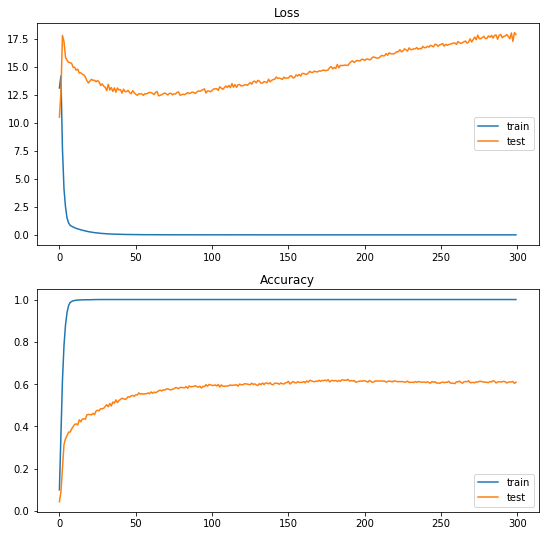

train acc: 1.0
train acc: 0.6087824106216431


In [13]:
# 1) create loss and accuracy plots
_, train_acc = model2.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model2.evaluate(X_test, Y_test, verbose=0)
# 1.1) plot loss during training
pyplot.figure(1, (9,9))
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# 1.2) plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()
print('train acc:', train_acc)
print('train acc:', test_acc)

In [14]:
# print out confusion matrix of predicted classifications
from sklearn.metrics import confusion_matrix
y_pred = model2.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis=-1)
Y_test = np.argmax(Y_test, axis=-1)
output_confusion_matrix = confusion_matrix(Y_test, y_pred)
print(output_confusion_matrix)
np.savetxt("model4_output_4_ext_spread.csv", output_confusion_matrix, delimiter=",")

1002/1002 [==============================] - 1s 1ms/step
[[24  5  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [12 16  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 2  0 14 17  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  2  6 21  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  2  2 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0 32  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  2  9  2  3  2  1  1  0  1  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  2  3 33  3  2  0  1  1  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  2  3 28  6  4  1  1  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  2  1 25  6  9  5  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  6 23  3  1  0  0  0  0  0  0  1  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  1  1  

In [15]:
# store train and dev set accuracy at each epoch
np.savetxt("model4_output_4_loss_ext_spread.csv", history.history['loss'], delimiter=",")
np.savetxt("model4_output_4_val_loss_ext_spread.csv", history.history['val_loss'], delimiter=",")
np.savetxt("model4_output_4_accuracy_ext_spread.csv", history.history['accuracy'], delimiter=",")
np.savetxt("model4_output_4_val_accuracy_ext_spread.csv", history.history['val_accuracy'], delimiter=",")